In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
test_unknown_data_path = './data/2_rf_test_unknown_data.csv'
test_unknown_data = pd.read_csv(test_unknown_data_path)

test_unknown_label_path = './data/2_rf_test_unknown_label.csv'
test_unknown_label = pd.read_csv(test_unknown_label_path)
test = './data/testing_data.csv'
test_data = pd.read_csv(test)

test_L= './data/testing_lable.csv'
test_L_data  = pd.read_csv(test_L)

In [ ]:
import pickle

In [ ]:
with open('./data/4_gan_data_v1.pkl', 'rb') as file:
    gan_data_v1 = pickle.load(file)
with open('./data/4_gan_label_v1.pkl', 'rb') as file:
    gan_label_v1 = pickle.load(file)

In [ ]:
with open('./data/4_gan_data_v2.pkl', 'rb') as file:
    gan_data_v2 = pickle.load(file)
with open('./data/4_gan_label_v2.pkl', 'rb') as file:
    gan_label_v2 = pickle.load(file)

In [ ]:
with open('./data/class_mapping.pkl', 'rb') as file:
    class_mapping = pickle.load(file)

In [ ]:
class_mapping

{'Backdoor_Malware': 0,
 'BenignTraffic': 1,
 'BrowserHijacking': 2,
 'CommandInjection': 3,
 'DDoS-ACK_Fragmentation': 4,
 'DDoS-HTTP_Flood': 5,
 'DDoS-ICMP_Flood': 6,
 'DDoS-ICMP_Fragmentation': 7,
 'DDoS-PSHACK_Flood': 8,
 'DDoS-RSTFINFlood': 9,
 'DDoS-SYN_Flood': 10,
 'DDoS-SlowLoris': 11,
 'DDoS-SynonymousIP_Flood': 12,
 'DDoS-TCP_Flood': 13,
 'DDoS-UDP_Flood': 14,
 'DDoS-UDP_Fragmentation': 15,
 'DNS_Spoofing': 16,
 'DictionaryBruteForce': 17,
 'DoS-HTTP_Flood': 18,
 'DoS-SYN_Flood': 19,
 'DoS-TCP_Flood': 20,
 'DoS-UDP_Flood': 21,
 'MITM-ArpSpoofing': 22,
 'Mirai-greeth_flood': 23,
 'Mirai-greip_flood': 24,
 'Mirai-udpplain': 25,
 'Recon-HostDiscovery': 26,
 'Recon-OSScan': 27,
 'Recon-PingSweep': 28,
 'Recon-PortScan': 29,
 'SqlInjection': 30,
 'Uploading_Attack': 31,
 'VulnerabilityScan': 32,
 'XSS': 33}

In [ ]:
# flip the dictionary. key into value, and vice versa
flipped_dict = dict((v, k) for k, v in class_mapping.items())

In [ ]:
gan_label_v1 = pd.DataFrame(gan_label_v1)
gan_label_v2 = pd.DataFrame(gan_label_v2)

In [ ]:
gan_label_v1

,label
0,1
1,1
2,1
3,1
4,1
...,...
16991,2
16992,7
16993,7
16994,4


In [ ]:
gan_label_v1['label'] = gan_label_v1['label'].replace(flipped_dict)
gan_label_v2['label'] = gan_label_v2['label'].replace(flipped_dict)

In [ ]:
gan_label_v1['label'].value_counts()

label
BenignTraffic              15149
DDoS-PSHACK_Flood            746
DDoS-ICMP_Fragmentation      580
DDoS-ACK_Fragmentation       373
DDoS-HTTP_Flood               55
DDoS-RSTFINFlood              40
BrowserHijacking              23
CommandInjection              13
Backdoor_Malware              12
DDoS-SlowLoris                 4
DDoS-ICMP_Flood                1
Name: count, dtype: int64

In [ ]:
attacks = ['DDoS', 'DoS', 'Mirai', 'Recon']

def mergeAttacks(dataframe, attacks):
    """ Merge attacks into big category

    Args:
        dataframe(Pandas dataframe): Contains specific attacks

    Return:
        (Pandas dataframe): merged dataframe
    """

    dataframe.loc[dataframe['label'].str.contains('DDoS'), 'label'] = 'andrew-nah'

    for attack in attacks:
        if attack == 'DDoS':
            continue
        dataframe.loc[dataframe['label'].str.contains(attack), 'label'] = attack
    
    dataframe.loc[dataframe['label'].str.contains('andrew-nah'), 'label'] = 'DDoS'
    
    return dataframe

# Merge attacks in syntesized data

In [ ]:
gan_label_v1 = mergeAttacks(gan_label_v1, attacks)
gan_label_v2 = mergeAttacks(gan_label_v2, attacks)

# Drop the major attacks; DDoS, DoS, Mirai

In [ ]:
def dropMajor(data, label):
    """ Drop the designated attacks

    Args:
        data(Pandas dataframe): data without labels
        label(Pandas dataframe): corresponding labels to data

    Return:
        (Pandas dataframe): dataframe without designated attacks

    """
    df = pd.concat([data, label], axis=1)
    df_filtered = df.drop(df[df['label'].isin(['DDoS', 'DoS', 'Mirai', 'Recon'])].index)
    return df_filtered


In [ ]:
gan_dropped_v1 = dropMajor(gan_data_v1, gan_label_v1)
gan_dropped_v2 = dropMajor(gan_data_v2, gan_label_v2)

In [ ]:
gan_dropped_v1['label'].value_counts()

label
BenignTraffic       15149
DDoS                 1799
BrowserHijacking       23
CommandInjection       13
Backdoor_Malware       12
Name: count, dtype: int64

In [ ]:
gan_dropped_v2['label'].value_counts()

label
BenignTraffic       5021
DDoS                 630
BrowserHijacking       7
CommandInjection       5
Backdoor_Malware       4
Name: count, dtype: int64

In [ ]:
gan_dropped_data_v1 = gan_dropped_v1.drop(columns=['label'])
gan_dropped_label_v1 = pd.DataFrame(gan_dropped_v1['label'])
gan_dropped_data_v2 = gan_dropped_v2.drop(columns=['label'])
gan_dropped_label_v2 = pd.DataFrame(gan_dropped_v2['label'])

# Merge original and synthesized data together

In [ ]:
gan_merged_data = pd.concat([gan_dropped_data_v1,gan_dropped_data_v2], axis=0)
gan_merged_label = pd.concat([gan_dropped_label_v1, gan_dropped_label_v2], axis=0)


In [ ]:
print("Shapes before merging:")
print("gan_merged_data shape:", gan_merged_data.shape)
print("gan_merged_label shape:", gan_merged_label.shape)
print("test_data shape:", test_unknown_data.shape)
print("test_label shape:", test_unknown_label.shape)

Shapes before merging:
gan_merged_data shape: (22663, 46)
gan_merged_label shape: (22663, 1)
test_data shape: (5728, 46)
test_label shape: (5728, 1)


In [ ]:
train_data = gan_merged_data
train_label = gan_merged_label

In [ ]:
gan_merged_label.value_counts()

label           
BenignTraffic       20170
DDoS                 2429
BrowserHijacking       30
CommandInjection       18
Backdoor_Malware       16
Name: count, dtype: int64

In [ ]:
test_unknown_label.value_counts()

label               
BenignTraffic           5067
Recon                    271
MITM-ArpSpoofing         199
DNS_Spoofing             138
DictionaryBruteForce      19
SqlInjection              13
BrowserHijacking           7
CommandInjection           5
Backdoor_Malware           4
DoS                        2
XSS                        2
VulnerabilityScan          1
Name: count, dtype: int64

In [ ]:
train_label.value_counts()

label           
BenignTraffic       20170
DDoS                 2429
BrowserHijacking       30
CommandInjection       18
Backdoor_Malware       16
Name: count, dtype: int64

In [ ]:
# Check shapes after merging
print("\nShapes after merging:")
print("train_data shape:", train_data.shape)
print("train_label shape:", train_label.shape)


Shapes after merging:
train_data shape: (22663, 46)
train_label shape: (22663, 1)


In [ ]:
# Display column names
print("Column names:")
print(train_data.columns)

# Display dataset shape
print("\nDataset shape:")
print(train_data.shape)


Column names:
Index(['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate',
       'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
       'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
       'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count',
       'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet',
       'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC',
       'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number',
       'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight'],
      dtype='object')

Dataset shape:
(22663, 46)


In [ ]:
# Print data types
print("\nData Types:")
print(train_data.dtypes)


Data Types:
flow_duration      float64
Header_Length      float64
Protocol Type      float64
Duration           float64
Rate               float64
Srate              float64
Drate              float64
fin_flag_number    float64
syn_flag_number    float64
rst_flag_number    float64
psh_flag_number    float64
ack_flag_number    float64
ece_flag_number    float64
cwr_flag_number    float64
ack_count          float64
syn_count          float64
fin_count          float64
urg_count          float64
rst_count          float64
HTTP               float64
HTTPS              float64
DNS                float64
Telnet             float64
SMTP               float64
SSH                float64
IRC                float64
TCP                float64
UDP                float64
DHCP               float64
ARP                float64
ICMP               float64
IPv                float64
LLC                float64
Tot sum            float64
Min                float64
Max                float64
AVG            

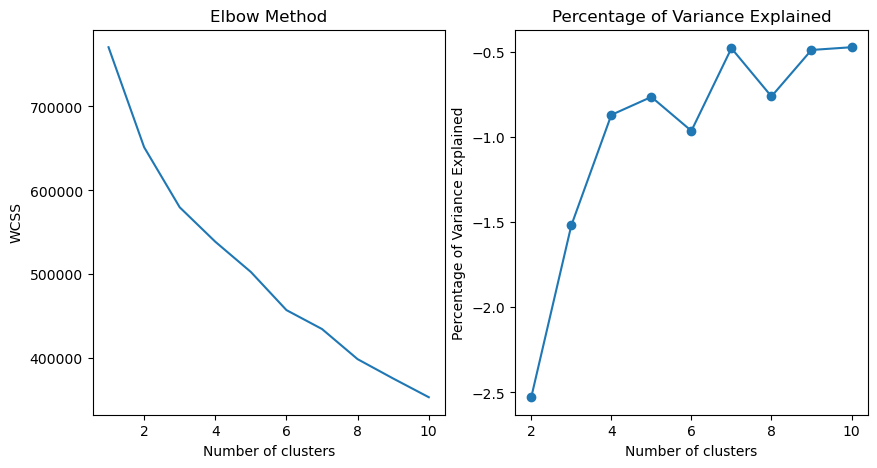

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Assuming 'test_unknown_data' is your dataset
data = train_data

# Step 4: Data Preprocessing
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Step 5: Choose the Number of Clusters (K)
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

# Calculate the percentage of variance explained
percentage_var_explained = np.diff(wcss) / np.sum(wcss[:-1]) * 100

# Plotting the elbow graph with the percentage of variance explained
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

plt.subplot(1, 2, 2)
plt.plot(range(2, 11), percentage_var_explained, marker='o')
plt.title('Percentage of Variance Explained')
plt.xlabel('Number of clusters')
plt.ylabel('Percentage of Variance Explained')
plt.show()


Silhouette Score: 0.23685188019064732


C:\Users\aravi\AppData\Local\Temp\ipykernel_5136\3889470198.py:33: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(range(len(test_cluster_labels)), test_cluster_labels, cmap='viridis', marker='o')


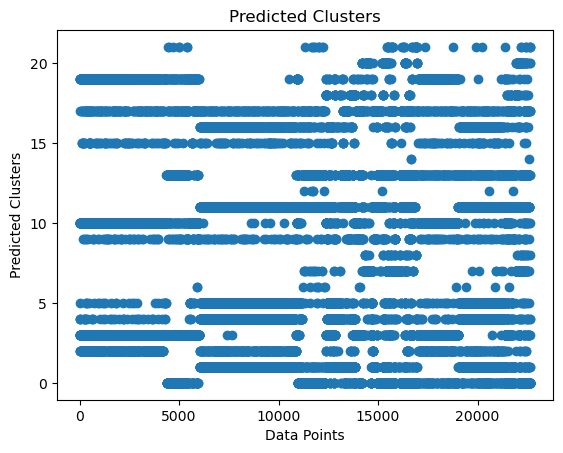

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Drop the 'Cluster' column if it exists
data_for_scaling = data.drop('Cluster', axis=1, errors='ignore')

# Step 4: Data Preprocessing
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_scaling)

# Manually set the optimal number of clusters based on the elbow method
your_optimal_k = 22

# Fit K-Means model to the training data
kmeans = KMeans(n_clusters=your_optimal_k, init='k-means++', max_iter=300, n_init=10, random_state=2)
kmeans.fit(scaled_data)

# Assuming your test data has the same features as the training data
scaled_test_data = scaler.transform(data_for_scaling)

# Predict the clusters for the test data
test_cluster_labels = kmeans.predict(scaled_test_data)

# Silhouette Score for clustering evaluation
silhouette_avg = silhouette_score(scaled_test_data, test_cluster_labels)
print(f"Silhouette Score: {silhouette_avg}")

# Plotting predicted clusters
plt.scatter(range(len(test_cluster_labels)), test_cluster_labels, cmap='viridis', marker='o')
plt.xlabel('Data Points')
plt.ylabel('Predicted Clusters')
plt.title('Predicted Clusters')
plt.show()


c:\Users\aravi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


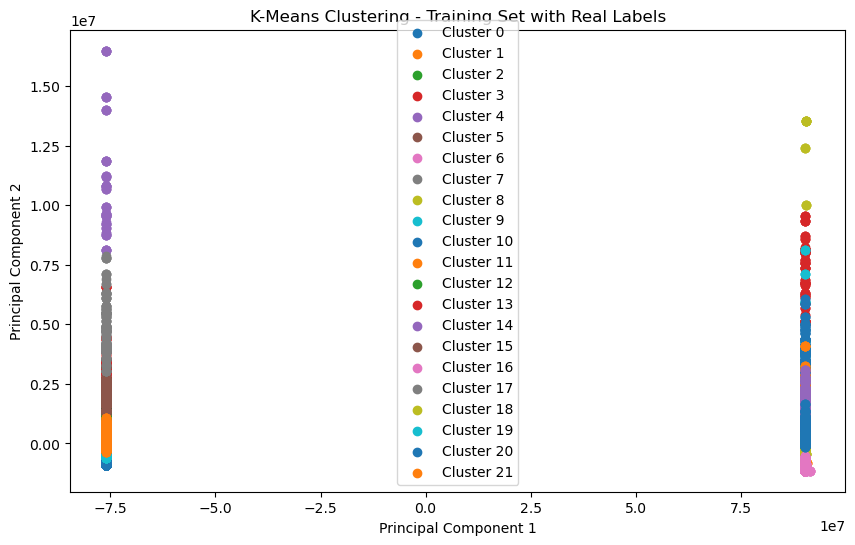

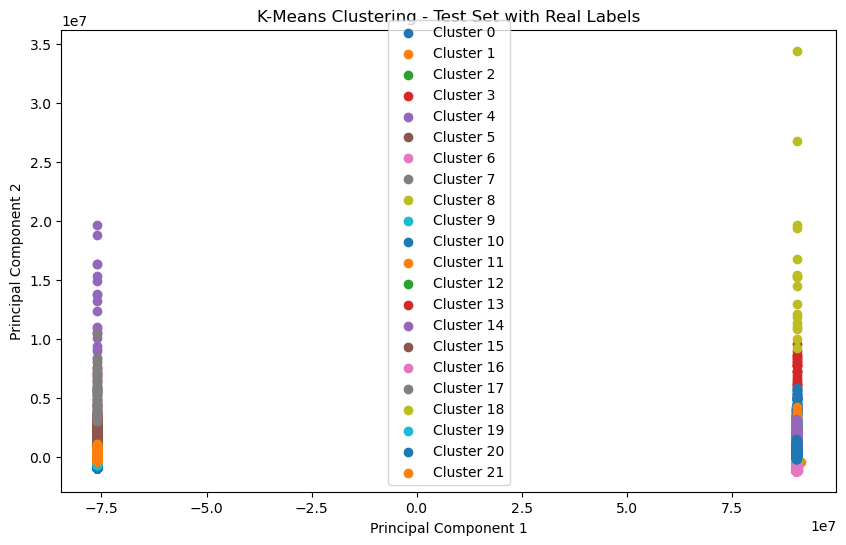

In [ ]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, normalized_mutual_info_score
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import numpy as np


X = train_data
y = train_label['label'] 

# Apply label encoding to the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train = X
y_train = y

X_test = test_data
y_test = test_L_data

# Specify the number of clusters
number_of_clusters = 22

# Apply k-means clustering on the training set
kmeans = KMeans(n_clusters=number_of_clusters, random_state=42)
train_predicted_labels = kmeans.fit_predict(X_train)

# Apply the clustering model to the test set
test_predicted_labels = kmeans.predict(X_test)

# Visualize clusters using PCA for dimensionality reduction
pca = PCA(n_components=2)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

# Scatter plot for training set with real labels
plt.figure(figsize=(10, 6))
for cluster in range(number_of_clusters):
    cluster_mask = (train_predicted_labels == cluster)
    plt.scatter(X_train_reduced[cluster_mask, 0], X_train_reduced[cluster_mask, 1], label=f'Cluster {cluster}')

plt.title('K-Means Clustering - Training Set with Real Labels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

# Scatter plot for test set with real labels
plt.figure(figsize=(10, 6))
for cluster in range(number_of_clusters):
    cluster_mask = (test_predicted_labels == cluster)
    plt.scatter(X_test_reduced[cluster_mask, 0], X_test_reduced[cluster_mask, 1], label=f'Cluster {cluster}')

plt.title('K-Means Clustering - Test Set with Real Labels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd

def scenario_4b():
    X = X_test
    y_true = y_test['label']
    
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled_train = scaler.fit_transform(X_train)
    
    # Apply PCA for dimensionality reduction to 2 components
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    X_pca_train = pca.fit_transform(X_scaled_train)
    
    # Apply k-means clustering on the reduced dataset
    # Assuming X_pca_train is a NumPy array
    nan_count = np.isnan(X_pca_train).sum()
    
    print(f"Number of NaN elements in X_pca_train: {nan_count}")
    # MAIN CHANGE!!
    number_of_clusters = 22
    kmeans = KMeans(n_clusters=number_of_clusters, random_state=42)
    predicted_labels_train_data = kmeans.fit(X_scaled_train)
    predicted_labels_train = kmeans.predict(X_scaled_train)
    predicted_labels = kmeans.predict(X_scaled)
    
    #inertia
    inertia_model1 = kmeans.inertia_
    print("Inertia (Model 5):", inertia_model1)
    
    #silheoutte
    silhouette_score_model1 = silhouette_score(X, y_true)
    print("Silhouette Score (Model 5):", silhouette_score_model1)
    
    # Calculate Calinski-Harabasz Index
    calinski_harabasz_model1 = calinski_harabasz_score(X, y_true)
    print("Calinski-Harabasz Index (Model 5):", calinski_harabasz_model1)
    
    # Calculate Davies-Bouldin Index
    davies_bouldin_model1 = davies_bouldin_score(X, y_true)
    print("Davies-Bouldin Index (Model 5):", davies_bouldin_model1)
    
    # Create a DataFrame to store the association between clusters and ground truth labels
    cluster_label_association = pd.DataFrame({'Cluster': predicted_labels, 'Ground Truth Label': y_true})
    cluster_label_association_train = pd.DataFrame({'Cluster': predicted_labels_train, 'Ground Truth Label': y})
    
    # Plot the association using a scatter plot
    plt.figure(figsize=(10, 6))
    
    # Plot data points without label names
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=predicted_labels, cmap='viridis', marker='o', edgecolors='k', label='Clustered Data')
    
    # Create a legend with cluster numbers
    legend_labels = list(range(number_of_clusters))
    plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.title('K-Means Clustering - Scatter Plot with Ground Truth Label Association (PCA)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    
    plt.show()
    
    # Plot the association using a scatter plot
    plt.figure(figsize=(10, 6))
    
    # Plot data points without label names
    scatter = plt.scatter(X_pca_train[:, 0], X_pca_train[:, 1], c=predicted_labels_train, cmap='viridis', marker='o', edgecolors='k', label='Clustered Data')
    
    # Create a legend with cluster numbers
    legend_labels = list(range(number_of_clusters))
    plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.title('K-Means Clustering - Scatter Plot with Ground Truth Label Association (PCA) (train)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    
    plt.show()
    
    # Plot the association using a scatter plot
    plt.figure(figsize=(10, 6))
    
    # Iterate over unique ground truth labels
    for label in y_true.unique():
        indices = cluster_label_association[cluster_label_association['Ground Truth Label'] == label].index
        plt.scatter(X_pca[indices, 0], X_pca[indices, 1], label=f'Ground Truth - {label}')
    
    # Add legend
    plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title('K-Means Clustering - Scatter Plot with Ground Truth Label Association (PCA)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    
    plt.show()
    print(cluster_label_association_train.size)
    print(X_pca_train.size)
    # Plot the association using a scatter plot
    plt.figure(figsize=(10, 6))
    
    # Iterate over unique ground truth labels
    for label in y_train.unique():
        indices = cluster_label_association_train[cluster_label_association_train['Ground Truth Label'] == label].index
        indices = indices[indices < X_pca_train.shape[0]]
        print(f'Label: {label}, Indices: {indices}, X_pca_train shape: {X_pca_train.shape}')
        plt.scatter(X_pca_train[indices, 0], X_pca_train[indices, 1], label=f'Ground Truth - {label}')
    
    # Add legend
    plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title('K-Means Clustering - Scatter Plot with Ground Truth Label Association (PCA)(train)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    
    plt.show()
    
    print(y_true.unique().size)
    print(y_train.unique().size)
    return inertia_model1, silhouette_score_model1, calinski_harabasz_model1, davies_bouldin_model1, cluster_label_association, cluster_label_association_train

inertia_model1, silhouette_score_model1, calinski_harabasz_model1, davies_bouldin_model1, cluster_label_association, cluster_label_association_train = scenario_4b()


c:\Users\aravi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


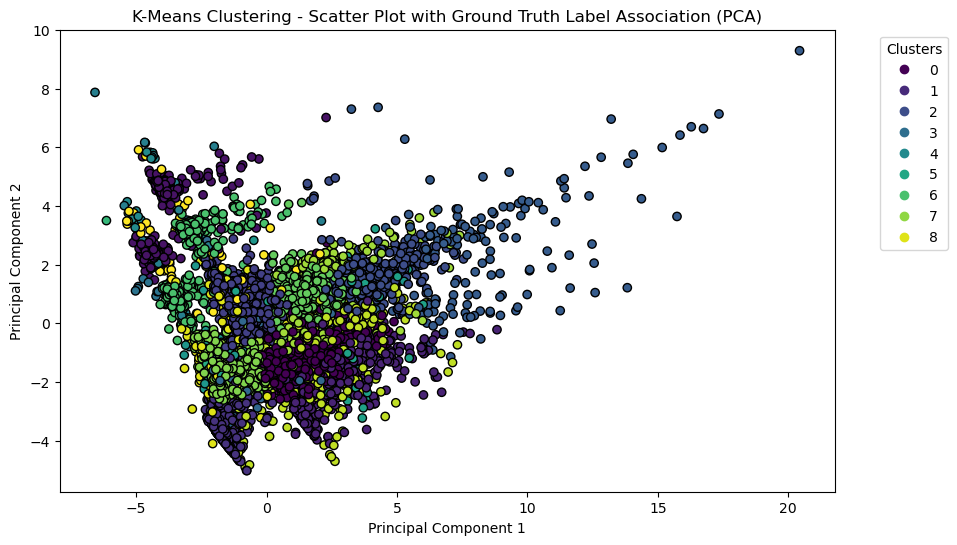

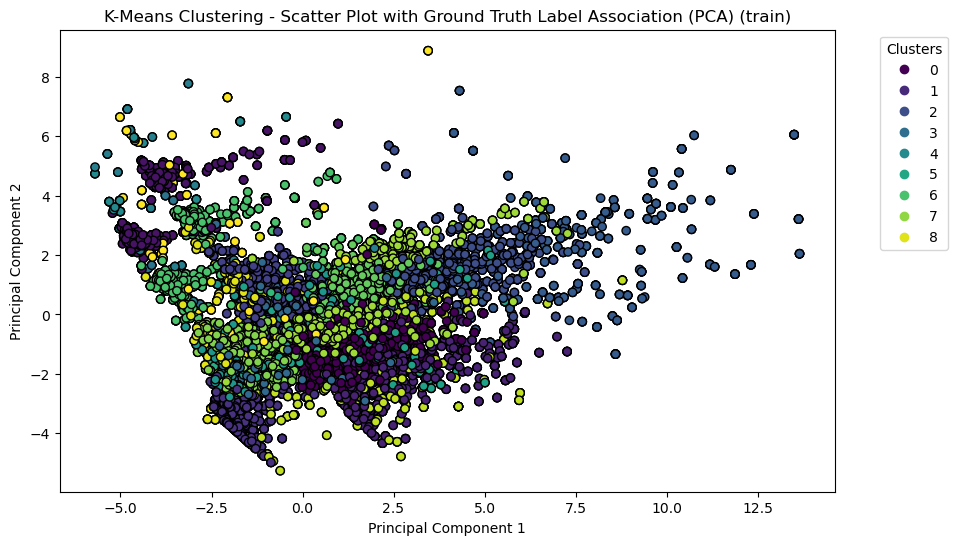

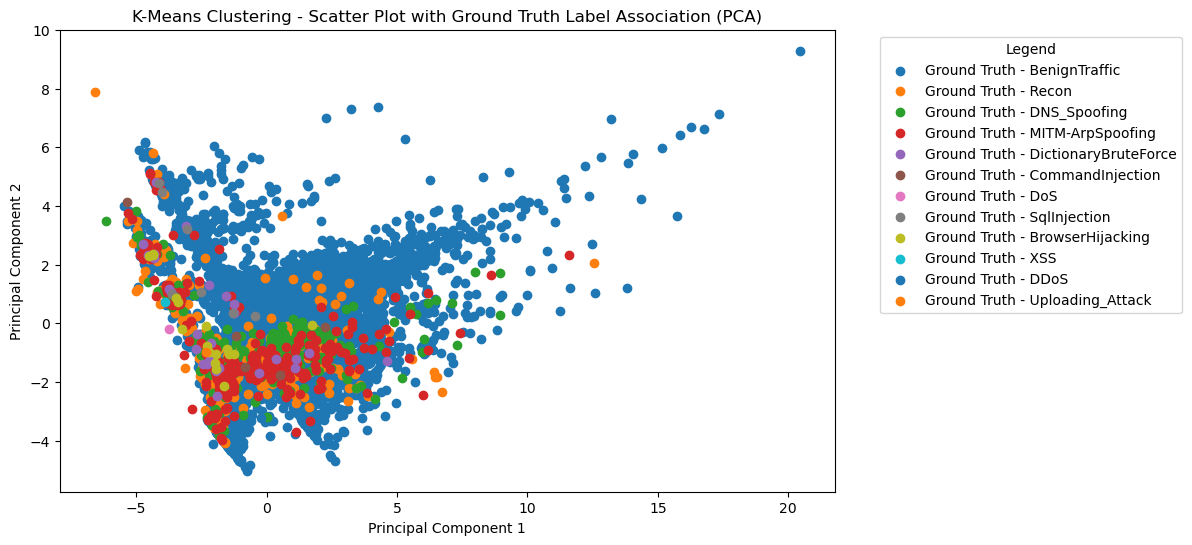

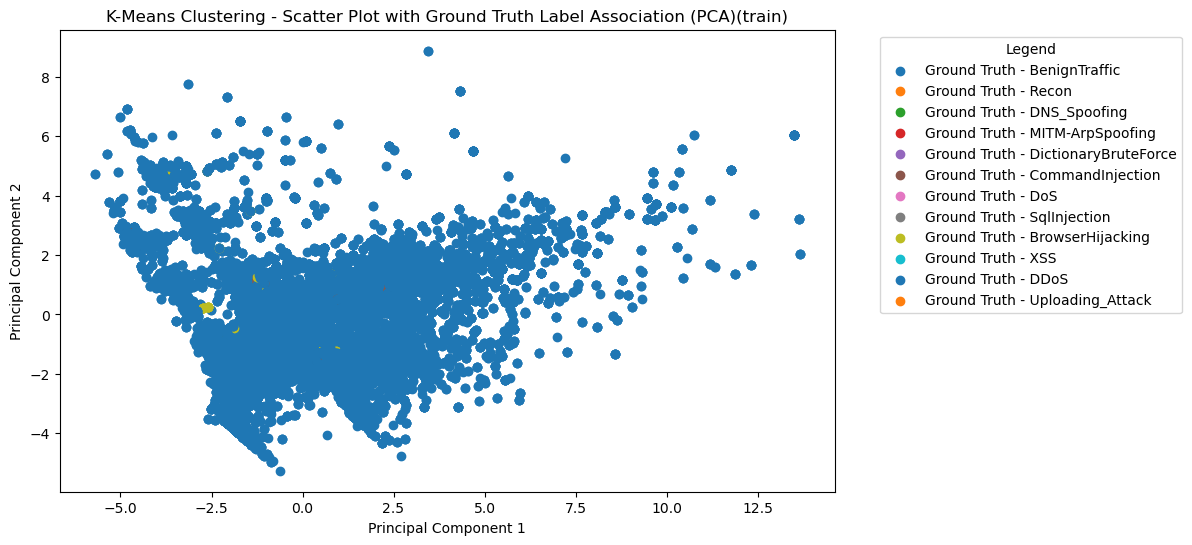

12
5
45326
45326


In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd
X_test = test_data
y_test = test_L_data
X = X_test
y_true = y_test['label']

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_train = scaler.fit_transform(X_train)

# Apply PCA for dimensionality reduction to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X_pca_train = pca.fit_transform(X_scaled_train)

# Apply k-means clustering on the reduced dataset

# MAIN CHANGE!!
number_of_clusters = 22
kmeans = KMeans(n_clusters=number_of_clusters, random_state=42)
predicted_labels_train_data = kmeans.fit(X_scaled_train)
predicted_labels_train = kmeans.predict(X_scaled_train)
predicted_labels = kmeans.predict(X_scaled)

# Create a DataFrame to store the association between clusters and ground truth labels
cluster_label_association = pd.DataFrame({'Cluster': predicted_labels, 'Ground Truth Label': y_true})
cluster_label_association_train = pd.DataFrame({'Cluster': predicted_labels_train, 'Ground Truth Label': y})
cluster_label_association_train_reset = cluster_label_association_train.reset_index(drop=True)
# Plot the association using a scatter plot
plt.figure(figsize=(10, 6))

# Plot data points without label names
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=predicted_labels, cmap='viridis', marker='o', edgecolors='k', label='Clustered Data')

# Create a legend with cluster numbers
legend_labels = list(range(number_of_clusters))
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('K-Means Clustering - Scatter Plot with Ground Truth Label Association (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.show()

# Plot the association using a scatter plot
plt.figure(figsize=(10, 6))

# Plot data points without label names
scatter = plt.scatter(X_pca_train[:, 0], X_pca_train[:, 1], c=predicted_labels_train, cmap='viridis', marker='o', edgecolors='k', label='Clustered Data')

# Create a legend with cluster numbers
legend_labels = list(range(number_of_clusters))
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('K-Means Clustering - Scatter Plot with Ground Truth Label Association (PCA) (train)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.show()

# Plot the association using a scatter plot
plt.figure(figsize=(10, 6))

# Iterate over unique ground truth labels
for label in y_true.unique():
    indices = cluster_label_association[cluster_label_association['Ground Truth Label'] == label].index
    plt.scatter(X_pca[indices, 0], X_pca[indices, 1], label=f'Ground Truth - {label}')

# Add legend
plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('K-Means Clustering - Scatter Plot with Ground Truth Label Association (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.show()

# Plot the association using a scatter plot
plt.figure(figsize=(10, 6))

for label in y_true.unique():
    indices = cluster_label_association_train[cluster_label_association_train['Ground Truth Label'] == label].index

    # Filter out-of-bound indices
    mask = (indices < len(X_pca_train))
    plt.scatter(X_pca_train[indices[mask], 0], X_pca_train[indices[mask], 1], label=f'Ground Truth - {label}')

# Add legend
plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('K-Means Clustering - Scatter Plot with Ground Truth Label Association (PCA)(train)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

print(y_true.unique().size)
print(y_train.unique().size)
print(cluster_label_association_train.size)
print(X_pca_train.size)


In [ ]:
cluster_label_association

,Cluster,Ground Truth Label
0,16,BenignTraffic
1,20,Recon
2,2,BenignTraffic
3,17,BenignTraffic
4,17,BenignTraffic
...,...,...
7112,15,BenignTraffic
7113,4,BenignTraffic
7114,3,BenignTraffic
7115,17,BenignTraffic


In [ ]:
cluster_label_association_train

,Cluster,Ground Truth Label
0,16,BenignTraffic
1,2,BenignTraffic
2,5,BenignTraffic
3,5,BenignTraffic
4,5,BenignTraffic
...,...,...
5662,20,DDoS
5663,1,DDoS
5664,4,DDoS
5665,1,BrowserHijacking


In [ ]:
cluster_gtl_counts = cluster_label_association.groupby('Cluster')['Ground Truth Label'].value_counts().unstack(fill_value=0)

In [ ]:
cluster_gtl_counts_train = cluster_label_association_train.groupby('Cluster')['Ground Truth Label'].value_counts().unstack(fill_value=0)

In [ ]:
print(cluster_gtl_counts)
print(cluster_gtl_counts_train)

Ground Truth Label  BenignTraffic  BrowserHijacking  CommandInjection  DDoS  \
Cluster                                                                       
0                             621                 0                 1     0   
1                             374                 3                 0     0   
2                             344                 1                 0     0   
3                             387                 0                 0     0   
4                             891                 0                 0     0   
5                             505                 0                 0     0   
6                             137                 0                 0     0   
7                              91                 0                 0     0   
8                               2                 0                 0     0   
9                              17                 0                 0     0   
10                              9                 0 

In [ ]:
cluster_b_ratio = (cluster_gtl_counts['BenignTraffic'] / cluster_gtl_counts.sum(axis=1)).fillna(0)

print(cluster_b_ratio)

cluster_b_ratio_train = (cluster_gtl_counts_train['BenignTraffic'] / cluster_gtl_counts_train.sum(axis=1)).fillna(0)

print("Training result - ", cluster_b_ratio_train)

Cluster
0     0.823607
1     0.809524
2     0.875318
3     0.881549
4     0.993311
5     0.992141
6     0.919463
7     0.910000
8     0.222222
9     0.850000
10    0.600000
11    0.711538
12    0.762590
13    0.000000
14    0.000000
15    0.789675
16    0.991724
17    0.782524
18    0.773946
19    0.996364
20    0.759076
21    0.910714
dtype: float64
Training result -  Cluster
0     0.859595
1     0.829054
2     0.872453
3     0.906122
4     0.994650
5     0.986318
6     0.934944
7     0.897311
8     0.733333
9     0.722222
10    0.734375
11    0.900000
12    0.699482
13    0.000000
14    0.000000
15    0.781866
16    0.991824
17    0.816358
18    0.809235
19    0.987849
20    0.825126
21    0.886905
dtype: float64


In [ ]:
X_train = train_data
y_train = train_label['label']

# Specify the number of clusters
number_of_clusters = 22  # Adjust as needed

# Fit K-Means model to the training data
kmeans = KMeans(n_clusters=number_of_clusters, random_state=42)
train_predicted_labels = kmeans.fit_predict(train_data)

scaled_test_data = scaler.transform(test_data)

# Predict the clusters for the test data
cluster_labels_test = kmeans.predict(test_data)

# Calculate the percentage of benign traffic in each cluster for the training set
cluster_benign_ratio_train = {}

benign_class_label = 'BenignTraffic'

for cluster_label in range(number_of_clusters): 
    cluster_mask = (train_predicted_labels == cluster_label)
    
    # Calculate the denominator
    denominator = np.sum(cluster_mask)
    
    # Check if the denominator is greater than zero before performing the division
    if denominator > 0:
        cluster_benign_ratio_train[cluster_label] = np.sum(y_train[cluster_mask] == benign_class_label) / denominator
    else:
        cluster_benign_ratio_train[cluster_label] = 0  # or any other value you consider appropriate
for cluster_label, benign_ratio in cluster_benign_ratio_train.items():
    print(f"Cluster {cluster_label}: Benign Ratio = {benign_ratio}")

test_data_indices = range(len(y_true))
# adjust this threshold based on the criteria
benign_thresholds = [0.01, 0.1, 0.25, 0.5, 0.75, 0.95, 0.99]

for threshold in benign_thresholds:
    clusters_labeled_as_benign = [cluster_label for cluster_label, ratio in cluster_benign_ratio_train.items() if ratio > threshold]

    false_positive_indices = [idx for idx in test_data_indices if cluster_labels_test[idx] in clusters_labeled_as_benign and y_true[idx] != benign_class_label]

    fpr = len(false_positive_indices) / len(test_data_indices)
    print(f"Threshold: {threshold}, False Positive Rate (FPR): {fpr}")
    print("Clusters Labeled as Benign:", clusters_labeled_as_benign)
    num_clusters_labeled_as_benign = len(clusters_labeled_as_benign)
    print("Number of Clusters Labeled as Benign:", num_clusters_labeled_as_benign)
    print("False Positive Indices:", false_positive_indices)
    print("\n")



c:\Users\aravi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster 0: Benign Ratio = 0.7281781963056864
Cluster 1: Benign Ratio = 0.9854430379746836
Cluster 2: Benign Ratio = 0.9411764705882353
Cluster 3: Benign Ratio = 1.0
Cluster 4: Benign Ratio = 0.8923076923076924
Cluster 5: Benign Ratio = 1.0
Cluster 6: Benign Ratio = 0.7974137931034483
Cluster 7: Benign Ratio = 0.9364406779661016
Cluster 8: Benign Ratio = 0.9791356184798807
Cluster 9: Benign Ratio = 1.0
Cluster 10: Benign Ratio = 0.9912280701754386
Cluster 11: Benign Ratio = 0.9946332737030411
Cluster 12: Benign Ratio = 0.8863109048723898
Cluster 13: Benign Ratio = 1.0
Cluster 14: Benign Ratio = 0.9900596421471173
Cluster 15: Benign Ratio = 0.9924433249370277
Cluster 16: Benign Ratio = 0.9626384952331873
Cluster 17: Benign Ratio = 0.8235294117647058
Cluster 18: Benign Ratio = 1.0
Cluster 19: Benign Ratio = 0.8941480206540448
Cluster 20: Benign Ratio = 0.9902597402597403
Cluster 21: Benign Ratio = 0.6906729634002361
Threshold: 0.01, False Positive Rate (FPR): 0.12659828579457635
Clusters 